### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import anndata
import scanpy as sc

In [2]:
import seaborn as sns

In [3]:
from torch import nn
from tqdm.notebook import tqdm 
from itertools import chain

In [4]:
from ot_cond.utils import set_seed, createLogHandler, get_G_v2 as get_G, get_dist
from torch import nn
from tqdm import tqdm 
from itertools import chain
from torch.optim import Adam,RMSprop, SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from torch.nn import functional as F

In [5]:
%cd ../../../../../examples/bio_new

[Errno 2] No such file or directory: '../../../../../examples/bio_new'
/raid/rachitkd/Conditional-Optimal-Transport/examples/bio_new


In [6]:
import argparse
import os

In [7]:
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel

In [8]:
import jax.numpy as jnp
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.geometry import pointcloud

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
SEED = 0
set_seed(SEED)

### Load Data

In [11]:
def read_data(filename='hvg.h5ad'):
    adata = sc.read(filename)
    sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)

    dat = adata.obsm['X_pca']

    # Separate out control cells, 
    ctrl_indices = np.where(adata.obs['dose'].to_numpy()==0)[0]
    print(f'Number of control cells:{len(ctrl_indices)}')
    ctrl_data = dat[ctrl_indices]
    
    # Different y distributions
    y_1 = dat[np.where(adata.obs['drug-dose'].to_numpy()=='givinostat-10')]
    y_2 = dat[np.where(adata.obs['drug-dose'].to_numpy()=='givinostat-100')]
    y_3 = dat[np.where(adata.obs['drug-dose'].to_numpy()=='givinostat-1000')]
    y_4 = dat[np.where(adata.obs['drug-dose'].to_numpy()=='givinostat-10000')]

    return ctrl_data, y_1, y_2, y_3, y_4

def split_data(X, Y1, Y2 , Y3, Y4):
    """
    Split data into training and test datasets
    """
    train_set = []
    test_set = []
    for each in (X, Y1, Y2, Y3, Y4):
        each_train, each_test = train_test_split(each, test_size=0.2, random_state=0)
        train_set.append(each_train)
        test_set.append(each_test)
    
    return tuple(train_set), tuple(test_set)

def get_dataloaders(dataset, batch_size=512):
    """
    Dataset here is not a pytorch dataset, but rather a tuple
    """
    tensor_dl = {}
    
    source_dset = TensorDataset(torch.from_numpy(dataset[0]).float())
    source_dl = DataLoader(source_dset, batch_size=batch_size ,shuffle=True)    
                                
    doses = [10,100,1000,10000]
    for i, each in enumerate(dataset):
        if i == 0:
            continue
        each_dset =TensorDataset(torch.from_numpy(each).float())
        print(torch.from_numpy(each).shape)
        
        dl = DataLoader(each_dset, batch_size=batch_size ,shuffle=True)    
        tensor_dl[doses[i-1]] = dl
    
    # TODO: convert into dict
    return source_dl, tensor_dl

def get_data(filename='hvg.h5ad',setting='insample'):
    """
    Return train and test dataloaders
    """
    X, y_1, y_2, y_3, y_4 = read_data(filename)
    train_set, test_set = split_data(X, y_1, y_2, y_3, y_4)
    X_train_dataloader, Y_train_dataloaders = get_dataloaders(train_set)
    X_test_dataloader, Y_test_dataloaders = get_dataloaders(test_set)

    return X_train_dataloader, Y_train_dataloaders, X_test_dataloader, Y_test_dataloaders


### Define Networks

In [12]:
class Generator(nn.Module):
    def __init__(self, input_dim=50,context_dim=1, out_dim=50, noise_dim=10):
        super(Generator,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(noise_dim+context_dim+input_dim,128, bias=True),
            nn.LeakyReLU(0.1),
            nn.Linear(128,128),
            #nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(128,128),
            #nn.Dropout(0.1),
            nn.LeakyReLU(0.1),
            nn.Linear(128,64),
            #nn.Dropout(0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(64, out_dim),
        )
        
        self.input_dim = input_dim
        self.context_dim = context_dim
        self.noise_dim = noise_dim
    
    def forward(self,x):
        out = self.layers(x)
        return out

# Copy Piyushi Di's initialize_weights function 
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

### UTil

In [13]:

def eye_like(G):
    if(len(G.shape) == 3):
        return torch.eye(*G.shape[-2:], out=torch.empty_like(G)).repeat(G.shape[0], 1, 1)
    else: 
        return torch.eye(*G.shape,out=torch.empty_like(G))

In [14]:
def save_model(pi_net, optimizer, epoch):
    torch.save(pi_net.state_dict(),f'{save_as}/model_trained_{epoch}.pth')
    torch.save(optimizer.state_dict(),f'{save_as}/optimizer_trained_{epoch}.pth')
    return

### Hyperparameters

In [15]:

parser = argparse.ArgumentParser(description = '_')
parser.add_argument('--lda', type=float, default=2000) 
parser.add_argument('--ktype', type=str, default="imq")
parser.add_argument('--khp_x', type=float, default=10)
parser.add_argument('--khp_y', type=float, default=10)
parser.add_argument('--n_epochs', type=int, default=30)
parser.add_argument('--lr', type=float, default=2e-3)
parser.add_argument('--noise_dim', type=int, default=10)
parser.add_argument('--n_noise', type=int, default=20)
parser.add_argument('--opti_type', type=str, default="adam")
parser.add_argument('--log_fname', type=str, default="logs_final_run")
parser.add_argument('--save_as', required=False, type=str, default="")
args = parser.parse_args(args=[])
print(args)

Namespace(lda=2000, ktype='imq', khp_x=10, khp_y=10, n_epochs=30, lr=0.002, noise_dim=10, n_noise=20, opti_type='adam', log_fname='logs_final_run', save_as='')


In [16]:
# Hyperparameters
lambda_reg = args.lda
ktype = args.ktype
khp_x = args.khp_x
khp_y = args.khp_y
num_epochs = args.n_epochs
lr = args.lr
opti_type = args.opti_type
save_as = f"{lambda_reg}_{ktype}_{khp_x}_{khp_y}_{opti_type}_{args.noise_dim}" + args.save_as

n_noise = args.n_noise
noise_dim = args.noise_dim


### Instantiate

In [17]:
X_train_dataloader, Y_train_dataloaders, X_test_dataloader, Y_test_dataloaders =  get_data(filename='./datasets/hvg.h5ad')


Number of control cells:17565
torch.Size([812, 50])
torch.Size([790, 50])
torch.Size([654, 50])
torch.Size([575, 50])
torch.Size([204, 50])
torch.Size([198, 50])
torch.Size([164, 50])
torch.Size([144, 50])


In [18]:
pi_net = Generator(noise_dim=noise_dim)
pi_net.apply(initialize_weights)
pi_net = pi_net.to(device)
pi_net.train()

Generator(
  (layers): Sequential(
    (0): Linear(in_features=61, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=64, out_features=50, bias=True)
  )
)

In [19]:
optimizer = Adam(pi_net.parameters(), lr=lr, betas=(0.9,0.99))
#scheduler = StepLR(optimizer, step_size=100, gamma=0.8)

### Train

In [20]:
def train(pi_net, optimizer, X_train_dataloader, Y_train_dataloaders, scheduler=None):
    objs = []
    tcosts = []
    reg_costs = []
    best_obj = None # NOTE: ADDED
    v_gen = torch.Tensor(n_noise*[1.0/n_noise]).to(dtype).to(device)
    Z_qs = torch.Tensor([10,100,1000,10000]).to(dtype).to(device) 
    # IMP: The order of contexts here must be the same as order in Y_dataloaders
    # TODO: if out of sample, quit on the required context
    for epoch in tqdm(range(num_epochs)):
        obj_epoch = 0.
        #tcost_epoch = 0.
        #reg_epoch = 0.
        pi_net.train()
        
        for j in range(50):
            tcost_epoch = 0. 
            for idx, X_ in enumerate(X_train_dataloader):
                X = X_[0].to(device) # pytorch dataloader returns list, but we want only the first element
                obj = 0.
                tcost = 0.
                reg_y = 0.
                n_x = len(X)
                for ctx, dl in Y_train_dataloaders.items():
                    
                    ctx = torch.Tensor([ctx]).to(device)
                    
                    #Y_Z_ = next(iter(Y_train_dataloaders[10]))
                    
                    Y_Z_ = next(iter(dl))
                    Y_Z = Y_Z_[0].to(device)

                    #print(ctx.repeat(n_x,1).shape)
                    ZX = torch.cat([X, ctx.repeat(n_x,1)], dim=1)
                    n_s = torch.randn(n_noise*n_x, noise_dim).to(device)
                    #print(ZX.shape)
                    ZXn = torch.cat([ZX.repeat_interleave(n_noise,0), n_s],dim=1)
                    #print(ZXn.shape)
                    Y_gen = pi_net(ZXn)
                    
                    C = get_dist(X, Y_gen)
                    
                    reqd_indices = torch.eye(C.shape[0]).to(device).repeat_interleave(n_noise,dim=1)
                    C = C*reqd_indices / 100
                    # C = F.normalize(C, p=float('inf'), dim=[0,1])

                    #print(ZX.shape)
                    #print(ZXn.shape)
                    tcost = tcost + torch.sum(C)/(len(Z_qs)*(ZXn.shape[0]))

                obj = tcost

                # optimizer updates after looping for all Z
                tcost_epoch += obj
                optimizer.zero_grad()
                obj.backward()
                optimizer.step()
                if scheduler:
                    scheduler.step()
            print('c',tcost_epoch)
        
        for j in range(50):
            reg_epoch = 0.
            for idx, X_ in enumerate(X_train_dataloader):
                X = X_[0].to(device) # pytorch dataloader returns list, but we want only the first element
                obj = 0.
                tcost = 0.
                reg_y = 0.
                n_x = len(X)
                for ctx, dl in Y_train_dataloaders.items():
                    ctx = torch.Tensor([ctx]).to(device)
                    
                    ZX = torch.cat([X, ctx.repeat(n_x,1)], dim=1)
                    n_s = torch.randn(n_noise*n_x, noise_dim).to(device)
                    ZXn = torch.cat([ZX.repeat_interleave(n_noise,0), n_s],dim=1)
                    Y_gen = pi_net(ZXn)
                    
                    Y_Z_ = next(iter(dl))
                    Y_Z = Y_Z_[0].to(device)
                    k = Y_Z.shape[0]
                    sample_len = n_x*n_noise
                    v_gen = torch.Tensor(sample_len*[1.0/sample_len]).to(dtype).to(device)
                
                    v_ygz = -1*torch.Tensor(k*[1.0/k]).to(dtype).to(device)
                    v = torch.cat([v_gen, v_ygz], dim=0).to(dtype).to(device)
                
                
                    cat_Y = torch.vstack([Y_gen, Y_Z])
                
                    #v = (1/cat_Y.shape[0])*torch.ones(cat_Y.shape[0]).to(dtype).to(device)
                    G_cat = get_G(khp=khp_y, x=cat_Y, y=cat_Y, ktype=ktype)
                
                    #print(G_cat.shape, v.shape)
                    reg_y = reg_y + torch.mv(G_cat, v).dot(v)

                obj = lambda_reg*reg_y
            
                # optimizer updates after looping for all Z

                optimizer.zero_grad()
                obj.backward()
                optimizer.step()
                reg_epoch += obj
                if scheduler:
                    scheduler.step()
            print('r',reg_epoch)
            
            obj_epoch += obj
            #tcost_epoch += tcost
            #reg_epoch += reg_y
        #if epoch == 0:
        #    print(f'Cond No.{torch.linalg.cond(G_cat)}')
        #print(f'Tcost: {tcost_epoch}, reg_cost: {reg_epoch}, Objective: {obj_epoch}')
        
        objs.append(obj_epoch)
        tcosts.append(tcost_epoch)
        reg_costs.append(reg_epoch)
        print(obj_epoch, tcost_epoch, reg_epoch)
        

        if epoch % 50 == 0 and (best_obj is None or best_obj > objs[-1].item()):
            #cond_no = torch.linalg.cond(G_cat)
            #print(cond_no)
            best_obj = objs[-1].item()
            #save_model(pi_net, optimizer, epoch)
            #logger.info(f'{obj_epoch}, {tcost_epoch}, {reg_epoch}, {epoch}')


    return pi_net, optimizer

In [37]:
train(pi_net, optimizer, X_train_dataloader,Y_train_dataloaders, None)

  0%|          | 0/30 [00:00<?, ?it/s]

c tensor(15.0363, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(11.9085, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(10.1275, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(8.8706, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(7.7814, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(6.8672, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(6.0463, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(5.3008, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(4.6656, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(4.1191, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(3.5971, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(3.1195, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(2.6149, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(2.1800, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(1.8486, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(1.5600, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(1.2929, device='cuda:0', grad_fn=<AddBackward0>)
c tensor(1.

  0%|          | 0/30 [02:48<?, ?it/s]


KeyboardInterrupt: 

### Save Model

In [54]:
pi_net.eval()

Generator(
  (layers): Sequential(
    (0): Linear(in_features=61, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=64, out_features=50, bias=True)
  )
)

In [39]:
torch.save(pi_net.state_dict(),f"alt_model_{lr}.pth")

In [40]:
adata = sc.read('./datasets/hvg.h5ad')
inv_pcamatrix = np.linalg.pinv(adata.obsm['X_pca'])@adata.X.A

In [25]:
X_test_dataloader, Y_test_dataloaders

(<torch.utils.data.dataloader.DataLoader at 0x7f0c74193a30>,
 {10: <torch.utils.data.dataloader.DataLoader at 0x7f0c74193010>,
  100: <torch.utils.data.dataloader.DataLoader at 0x7f0c74193160>,
  1000: <torch.utils.data.dataloader.DataLoader at 0x7f0a0469ceb0>,
  10000: <torch.utils.data.dataloader.DataLoader at 0x7f0a0469c7c0>})

In [55]:
dosages = [10,100,1000,10000]
test_samples = {
    10: torch.Tensor([]),
    100: torch.Tensor([]),
    1000: torch.Tensor([]),
    10000: torch.Tensor([])
}
for dose in dosages:
    for idx, batch in enumerate(Y_test_dataloaders[int(f'{dose}')]):
        #print(test_samples)
        print(idx)
        if (test_samples[dose].nelement() != 0):
            test_samples[dose] = torch.cat((test_samples[dose],batch[0]),0)
        else:
            test_samples[dose] = batch[0]
        print(test_samples[dose].shape)
    test_samples[dose] = test_samples[dose]@inv_pcamatrix

0
torch.Size([204, 50])
0
torch.Size([198, 50])
0
torch.Size([164, 50])
0
torch.Size([144, 50])


In [27]:
def compute_drug_signature_differences(control, treated, pushfwd):
    base = control.mean(0)

    true = treated.mean(0)
    pred = pushfwd.mean(0)

    diff = true - pred
    return diff


In [28]:
def transport_cot(pi_net, batch, dose):

    n_x = len(batch)
    n_noise = 5
    noise_dim = 10
    ZX = torch.cat([batch, torch.Tensor([dose]).repeat(n_x,1)], dim=1).to(device)
    n_s = torch.randn(n_noise, noise_dim).to(device)
    ZXn = torch.cat([ZX.repeat_interleave(n_noise,0), n_s.repeat(n_x,1)],dim=1).to(device)
            
    with torch.no_grad():
        gen_batch = pi_net(ZXn).detach().cpu()

    return gen_batch

In [56]:
# Impute samples and concat them into a dataloader
gen_samples = {
    0: torch.Tensor([]),
    10: torch.Tensor([]),
    100: torch.Tensor([]),
    1000: torch.Tensor([]),
    10000: torch.Tensor([])
}

test_source = X_test_dataloader
for idx, batch_ in enumerate(test_source):
    batch = batch_[0]
    n_x = len(batch)
    # transport these cells below
    # and store in a sample
    gen_samples[0] = torch.cat((gen_samples[0],batch),0)
    
    
    ZX = torch.cat([batch, torch.Tensor([10]).repeat(n_x,1)], dim=1).to(device)
    n_s = torch.randn(n_noise, noise_dim).to(device)
    ZXn = torch.cat([ZX.repeat_interleave(n_noise,0), n_s.repeat(n_x,1)],dim=1).to(device)
            
    with torch.no_grad():
        gen_batch_10 = pi_net(ZXn).detach().cpu()
    gen_samples[10] = torch.cat((gen_samples[10],gen_batch_10),0)
    
    gen_batch_100 = transport_cot(pi_net, batch, 100)    
    gen_samples[100] = torch.cat((gen_samples[100],gen_batch_100),0)    
    
    gen_batch_1000 = transport_cot(pi_net, batch, 1000)    
    gen_samples[1000] = torch.cat((gen_samples[1000],gen_batch_1000),0) 
    
    gen_batch_10000 = transport_cot(pi_net, batch, 10000)    
    gen_samples[10000] = torch.cat((gen_samples[10000],gen_batch_10000),0)

for each in gen_samples.keys():
    gen_samples[each] = gen_samples[each].detach().cpu()@inv_pcamatrix
    print(gen_samples[each].shape)

torch.Size([3513, 1000])
torch.Size([70260, 1000])
torch.Size([17565, 1000])
torch.Size([17565, 1000])
torch.Size([17565, 1000])


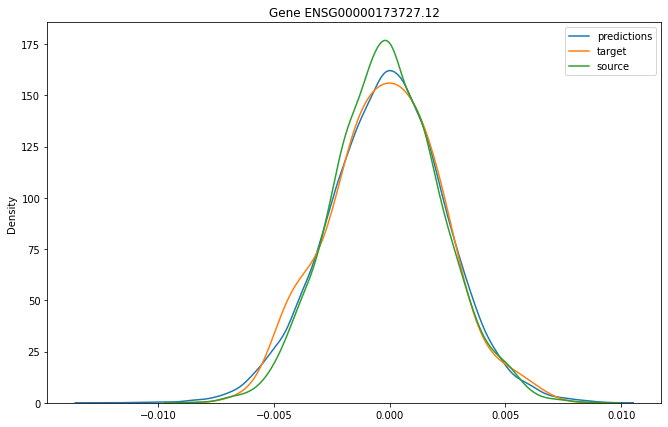

In [57]:
plt.figure(figsize=(11,7))
plt.title('Gene ENSG00000173727.12')
#print(generated[10].shape)
sns.kdeplot(gen_samples[100][:,1].detach().cpu().numpy(), label='predictions')
sns.kdeplot(test_samples[100][:,1].detach().cpu().numpy(), label='target')
sns.kdeplot(gen_samples[0][:,1].cpu().numpy(), label='source')
#sns.kdeplot(cellot_adata.X[:,581], label='cellOT')
plt.legend()
plt.show()

In [44]:
for dose in dosages:
    mean_diff = compute_drug_signature_differences(gen_samples[0], test_samples[dose] ,gen_samples[dose])
    print(torch.linalg.norm(mean_diff))

tensor(0.5214)
tensor(0.4145)
tensor(0.2872)
tensor(0.2634)


In [32]:
ctrl_indices = np.where(adata.obs['dose'].to_numpy()==0)[0]
drug_indices = np.where(adata.obs['drug'].to_numpy()=='givinostat')
arr = np.append(drug_indices, ctrl_indices)
# print(arr.shape)
adata_trunk_ = adata[arr]
print(adata_trunk_)
adata_trunk = sc.tl.rank_genes_groups(adata_trunk_,groupby='drug-dose',reference='control-0', n_genes=50,copy=True)
gene_names = adata_trunk.uns['rank_genes_groups']['names']
print(len(gene_names[0]))

View of AnnData object with n_obs × n_vars = 21106 × 1000
    obs: 'size_factor', 'cell_type', 'replicate', 'dose', 'drug_code', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'drug', 'drug-dose', 'drug_code-dose', 'n_genes'
    var: 'gene_short_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs', 'marker_genes-drug-rank', 'marker_genes-drug-score'
4


In [45]:
marker_indices = {10:[],100:[], 1000:[], 10000:[]}
for dose in marker_indices.keys():
    for i in range(1000):
        #print(type(adata_trunk.var.iloc[i].name))
        if adata_trunk.var.iloc[i].name in gene_names[f'givinostat-{dose}']:
            marker_indices[dose].append(i)
print(marker_indices)

{10: [3, 14, 18, 25, 37, 38, 40, 48, 49, 50, 62, 67, 99, 102, 112, 115, 118, 129, 201, 251, 254, 265, 312, 313, 322, 340, 364, 374, 375, 398, 414, 427, 485, 523, 525, 541, 561, 581, 597, 613, 632, 673, 710, 761, 795, 823, 840, 844, 928, 992], 100: [3, 7, 14, 18, 19, 22, 25, 40, 49, 50, 67, 85, 95, 102, 112, 129, 142, 181, 254, 265, 296, 312, 322, 340, 375, 398, 414, 427, 440, 504, 520, 525, 536, 541, 581, 613, 618, 632, 673, 710, 723, 761, 808, 823, 840, 844, 928, 933, 949, 957], 1000: [2, 3, 4, 7, 8, 9, 12, 19, 24, 40, 50, 59, 81, 86, 142, 166, 183, 245, 254, 297, 312, 313, 320, 352, 363, 398, 414, 504, 523, 536, 541, 559, 568, 581, 632, 686, 710, 723, 761, 763, 779, 823, 840, 844, 914, 928, 949, 952, 957, 976], 10000: [0, 2, 3, 4, 7, 8, 9, 12, 13, 16, 23, 31, 36, 40, 45, 55, 63, 78, 81, 86, 89, 90, 105, 127, 139, 140, 166, 192, 270, 298, 318, 327, 405, 504, 518, 536, 547, 559, 581, 686, 744, 770, 849, 852, 914, 949, 952, 976, 977, 986]}


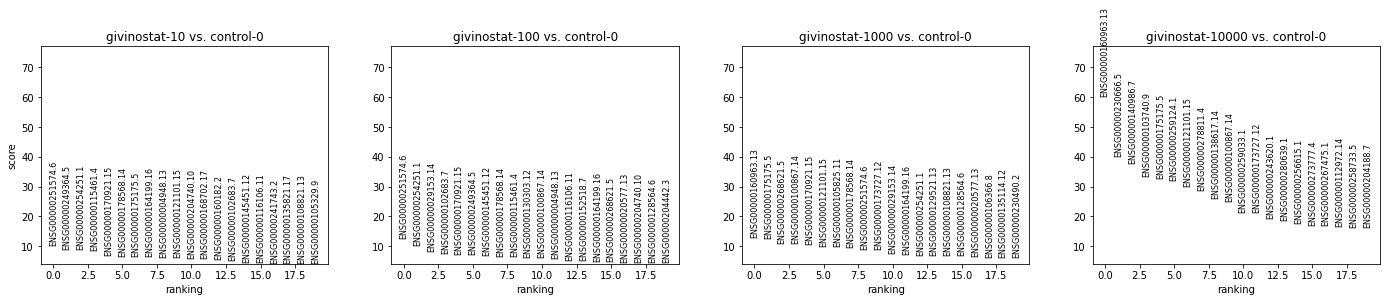

In [34]:
sc.pl.rank_genes_groups(adata_trunk)

In [58]:
# Perturbation Signatures, for all contexts and average.
for each_key in gen_samples.keys():
    print(each_key)
    if each_key == 0:
        
        continue
    gen_mean_vec = torch.mean(gen_samples[each_key],dim=0)
    y_mean_vec = torch.mean(test_samples[each_key],dim=0)
    l2_ps = torch.linalg.norm(gen_mean_vec[marker_indices[each_key]]- y_mean_vec[marker_indices[each_key]])
    print(l2_ps)

0
10
tensor(0.2995)
100
tensor(0.1499)
1000
tensor(0.1884)
10000
tensor(0.5122)


In [ ]:
# Lifted from CellOT
def mmd_distance(x, y, gamma):
    xx = rbf_kernel(x, x, gamma)
    xy = rbf_kernel(x, y, gamma)
    yy = rbf_kernel(y, y, gamma)

    return xx.mean() + yy.mean() - 2 * xy.mean()
 
def compute_scalar_mmd(target, transport, gammas=None):
    if gammas is None:
        gammas = [2, 1, 0.5, 0.1, 0.01, 0.005]

    def safe_mmd(*args):
        try:
            mmd = mmd_distance(*args)
        except ValueError:
            mmd = np.nan
        return mmd

    return np.mean(list(map(lambda x: safe_mmd(target, transport, x), gammas)))

In [ ]:

# for each_key in gen_samples.keys():
#     if each_key == 0:
#         continue
#     print(each_key)
#     mmd_dist = compute_scalar_mmd(gen_samples[each_key][:,marker_indices[each_key]].detach().cpu(),test_samples[each_key][:,marker_indices[each_key]].detach().cpu())
#     print(mmd_dist)

In [ ]:
def compute_wasserstein_loss(x, y, epsilon=0.1):
    """Computes transport between x and y via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    # compute cost
    geom_xy = pointcloud.PointCloud(x, y, epsilon=epsilon)
    prob = linear_problem.LinearProblem(geom_xy,a,b)
    # solve ot problem
    solver = sinkhorn.Sinkhorn()
    #out_xy = sinkhorn.Sinkhorn(geom_xy, a, b, max_iterations=100, min_iterations=10)
    out = solver(prob)
    # return regularized ot cost
    return out.reg_ot_cost


In [ ]:
# print('Computing Wass DistThe modified abstract .')
# for each_key in gen_samples.keys():
#     if each_key == 0:
#         continue
#     wdist = compute_wasserstein_loss(gen_samples[each_key][:,marker_indices[each_key]].detach().cpu().numpy(),test_samples[each_key][:,marker_indices[each_key]].cpu().numpy())
#     wdist = compute_wasserstein_loss(gen_samples[each_key].detach().cpu().numpy(),test_samples[each_key].cpu().numpy())
#     print(f'{each_key}:{wdist}')

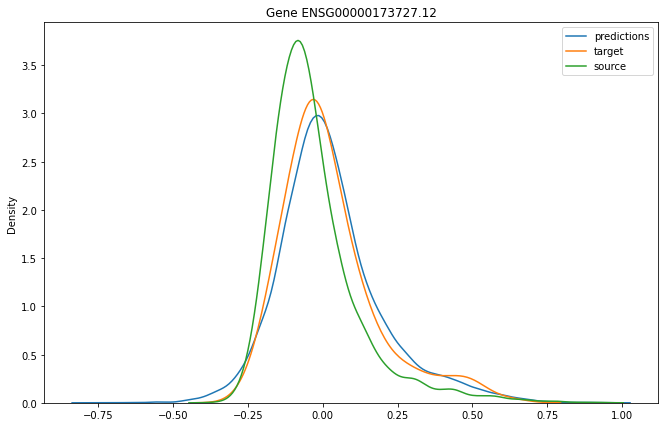

In [59]:
plt.figure(figsize=(11,7))
plt.title('Gene ENSG00000173727.12')
#print(generated[10].shape)
sns.kdeplot(gen_samples[100][:,976].detach().cpu().numpy(), label='predictions')
sns.kdeplot(test_samples[100][:,976].detach().cpu().numpy(), label='target')
sns.kdeplot(gen_samples[0][:,976].cpu().numpy(), label='source')
#sns.kdeplot(cellot_adata.X[:,581], label='cellOT')
plt.legend()
plt.show()